# Lung Disease Classification using Machine Learning

## Introduction

In recent times, the COVID-19 pandemic has highlighted the importance of effective diagnosis and classification of lung diseases. Machine learning models can play a crucial role in automating this process, aiding healthcare professionals in making accurate and timely decisions. In this project, we aim to develop a machine learning model capable of classifying chest X-ray images into three categories: healthy lungs, COVID-19 affected lungs, and lungs with pneumonia.

## Motivation

The identification and classification of lung diseases such as COVID-19 and pneumonia present several challenges:

1. **Manual Diagnosis Limitations:** Traditional diagnosis methods rely heavily on visual inspection by radiologists, which can be time-consuming and subjective.
2. **Rapid Screening Needs:** With the history of the rapid spread of diseases like COVID-19, there is a growing need for automated screening tools to assist healthcare workers in triaging patients effectively.
3. **Data Volume and Variability:** Building accurate machine learning models requires a large and diverse dataset of chest X-ray images, which may be challenging to obtain due to privacy concerns and data imbalance.
4. **Class Imbalance:** Lung disease datasets often suffer from class imbalance, with fewer instances of COVID-19 cases compared to healthy and pneumonia cases, making it harder for models to learn effectively.

## Project Overview

In this Jupyter Notebook, we will:

- Preprocess the chest X-ray images to prepare them for model training.
- Build and train a (CNN) and (MLP) model using TensorFlow/Keras to classify the images.
- Evaluate the model's performance using metrics such as accuracy, precision, recall, and F1-score.
- Discuss potential enhancements and future directions for improving the model's performance and usability in real-world healthcare settings.

By the end of this project, we aim to develop a robust and accurate machine learning model that can assist healthcare professionals in diagnosing and classifying lung diseases more efficiently.


In [1]:
import random
import os
import glob 
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc

import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Context-Free Grammar (CFG):
class CFG:
    EPOCHS= 50
    BATCH_SIZE= 64
    SEED= 42
    TF_SEED= 768
    HEIGHT= 224
    WIDTH= 224
    CHANNELS= 3
    IMAGE_SIZE=(224,224,3)

# Dataset Summary

The dataset consists of chest X-ray images collected for the classification of lung diseases, including COVID-19, pneumonia, and normal healthy lungs.

## Description

- **Image Type:** Gray-scale
- **Image Size:** 256 x 256 pixels
- **Number of Channels:** 1 (gray)
- **File Format:** Images are stored in common formats such as JPEG or PNG.
- **Image Dimension:** All images have the same dimensions of 256 x 256 pixels.

## Dataset Structure

The dataset is divided into training and testing sets, organized into directories as follows:

### Training Set

- **Total Samples:** 5044 images
    - COVID-19: 460 images
    - Pneumonia: 3418 images
    - Normal: 1266 images
    
### Testing Set

- **Total Samples:** 733 images
    - COVID-19: 116 images
    - Pneumonia: 855 images
    - Normal: 317 images
    
The training set contains a larger number of samples compared to the testing set, with a balanced distribution of classes among COVID-19, pneumonia, and normal cases.

In [3]:
DATASET_PATH="../input/chest-xray-covid19-pneumonia/Data/"
TRAIN_PATH=  "../input/chest-xray-covid19-pneumonia/Data/train/"
TEST_PATH= "../input/chest-xray-covid19-pneumonia/Data/test/"

In [4]:
#Generate a summary of dataset:

print("DATASET SUMMARY")
print("---------------------------------------")

for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    print(f'there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')
print('\n---------------------------------------')
    

DATASET SUMMARY
---------------------------------------
there are 2 directories and 0 images in ../input/chest-xray-covid19-pneumonia/Data/
there are 3 directories and 0 images in ../input/chest-xray-covid19-pneumonia/Data/test
there are 0 directories and 855 images in ../input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA
there are 0 directories and 317 images in ../input/chest-xray-covid19-pneumonia/Data/test/NORMAL
there are 0 directories and 116 images in ../input/chest-xray-covid19-pneumonia/Data/test/COVID19
there are 3 directories and 0 images in ../input/chest-xray-covid19-pneumonia/Data/train
there are 0 directories and 3418 images in ../input/chest-xray-covid19-pneumonia/Data/train/PNEUMONIA
there are 0 directories and 1266 images in ../input/chest-xray-covid19-pneumonia/Data/train/NORMAL
there are 0 directories and 460 images in ../input/chest-xray-covid19-pneumonia/Data/train/COVID19

---------------------------------------


In [5]:
train_images= glob.glob(f'{TRAIN_PATH}**/*.jpg')
test_images= glob.glob(f'{TEST_PATH}**/*.jpg')

In [6]:
train_size= len(train_images)
test_size= len(test_images)

total= train_size+test_size
print(f'Total: {total}')

Total: 6432


In [7]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]
def build_df(image_paths, labels):
    df= pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })
    
    df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'COVID19' else 1 if row.label == 'NORMAL' else 2, axis=1)


    return df.sample(frac=1, random_state= CFG.SEED).reset_index(drop=True)

In [8]:
#  Build the datafram

train_df= build_df(train_images, generate_labels(train_images))
test_df= build_df(test_images, generate_labels(test_images))

In [9]:
# View frist some sample in training and testing set 

train_df.head(5)

,image_path,label,label_encoded
0,../input/chest-xray-covid19-pneumonia/Data/tra...,COVID19,0
1,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA,2
2,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA,2
3,../input/chest-xray-covid19-pneumonia/Data/tra...,NORMAL,1
4,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA,2


In [10]:
def _load(image_path):
    # Read the image from the file
    image = tf.io.read_file(image_path)
    # Decode the image to a uint8 tensor
    image = tf.io.decode_image(image, channels=3)
    # Resize the image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH], method=tf.image.ResizeMethod.LANCZOS3)
    return image


In [11]:
 def view_sample(image, label, color_map='rgb',fig_size=(6,4)):
    plt.figure(figsize=fig_size)
    if color_map== 'rgb':
        plt.imshow(image)
    else:
        plt.imshow(tf.image.rgb_to_grayscale(image), cmap= color_map)
    plt.title(f'label:{label}', fontsize= 16)
    return

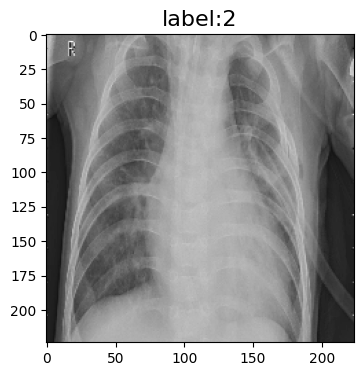

In [12]:
#select random sample from train_df
idx= random.sample(train_df.index.to_list(),1)[0]
#load the random sample and label
#sample_image, sample_label= _load(train_df.image_path[idx])
sample_image = _load(train_df.image_path[idx])
sample_label = train_df.label_encoded[idx]

#view the random sample colormap= gray
view_sample(sample_image, sample_label, color_map='gray')

In [13]:
# View multiple samples:
def view_multiple_samples(df,sample_loader, count=10, color_map='rgb', fig_size=(14,10)):
    rows= count//5
    if rows%5>0:
        rows+=1
    idx= random.sample(df.index.to_list(), count)
    fig= plt.figure(figsize=fig_size)
    
    for colum,_ in enumerate(idx):
        plt.subplot(rows,5,colum+1)
        plt.title(f'Label: {df.label[_]}')
        if color_map=='rgb':
            plt.imshow(sample_loader(df.image_path[_]))
        else:
            plt.imshow(tf.image.rgb_to_grayscale(sample_loader(df.image_path[_])), cmap=color_map)
    return

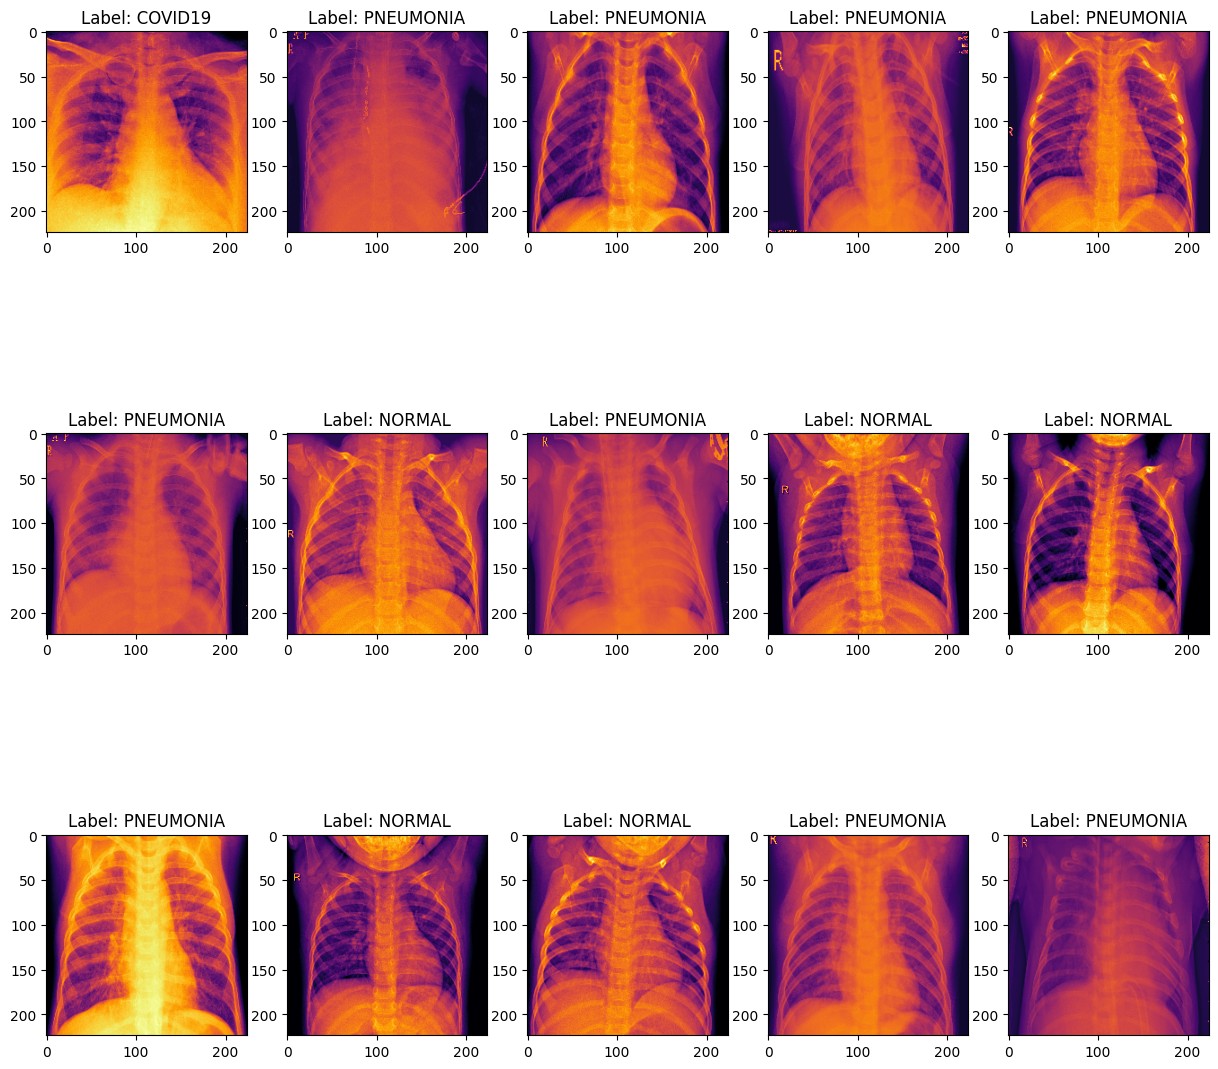

In [14]:
view_multiple_samples(train_df, _load, count=15, color_map='inferno', fig_size=(15,20))

# Exploratory Data Analysis (EDA) Summary

In this section, we visualize the chest X-ray images of COVID-19, normal, and pneumonia cases using the inferno color map to gain insights into the characteristics of each class.


- The COVID-19 X-ray images exhibit patterns of opacity and infiltrates, often concentrated in specific areas of the lungs. These images may show ground-glass opacities, consolidation, or bilateral lung involvement, indicative of COVID-19 pneumonia.

- The normal X-ray images demonstrate clear lung fields with no evidence of opacities or infiltrates. The lung structures are well-defined, and the images exhibit uniformity in grayscale intensity, indicating healthy lung tissue.

- The pneumonia X-ray images show various abnormalities such as patchy infiltrates, airspace consolidation, and/or pleural effusions. These abnormalities may appear as areas of increased opacity or haziness in the lung fields, suggesting inflammation or infection.

## EDA Conclusions

- COVID-19 X-ray images often exhibit bilateral involvement and patterns indicative of pneumonia, such as ground-glass opacities.
- Normal X-ray images demonstrate clear lung fields without any signs of abnormal opacities or infiltrates.
- Pneumonia X-ray images show diverse abnormalities, including consolidation and infiltrates, which may vary in severity and distribution across the lung fields.
- The inferno color map highlights subtle variations in grayscale intensity, aiding in the visualization of abnormalities and patterns specific to each class.

These visual observations provide valuable insights into the characteristics of chest X-ray images associated with COVID-19, pneumonia, and normal lung conditions, which can aid in the development of accurate classification models.

Overall however, the differences between these labels are hard to identify with the human eye

In [15]:
#create train/ val split with training
train_split_idx, val_split_idx,_,_= train_test_split(train_df.index,
                                                    train_df.label_encoded,
                                                    test_size= 0.15,
                                                    stratify=train_df.label_encoded,
                                                    random_state= CFG.SEED)

In [16]:
#Get new training and validation data

train_new_df= train_df.iloc[train_split_idx].reset_index(drop=True)
val_df= train_df.iloc[val_split_idx].reset_index(drop=True)
#view shape
train_new_df.shape, val_df.shape
train_new_df

,image_path,label,label_encoded
0,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA,2
1,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA,2
2,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA,2
3,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA,2
4,../input/chest-xray-covid19-pneumonia/Data/tra...,NORMAL,1
...,...,...,...
4367,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA,2
4368,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA,2
4369,../input/chest-xray-covid19-pneumonia/Data/tra...,NORMAL,1
4370,../input/chest-xray-covid19-pneumonia/Data/tra...,COVID19,0


## Summary of Augmentation Layer

In this project, an augmentation layer has been created to enhance the diversity and robustness of the training data used for model training. The augmentation layer consists of the following transformations:

1. **Random Flip (Horizontal and Vertical):**
   - This transformation randomly flips the input images horizontally and vertically, introducing variations in orientation. By flipping images, the model can learn to recognize features from different perspectives, improving its ability to generalize to unseen data.

2. **Random Zoom:**
   - The random zoom transformation applies random zooming to the input images, both horizontally and vertically. This augmentation technique introduces variations in scale, enabling the model to learn from images of different sizes and aspect ratios. By zooming in or out, the model can better capture fine details or global patterns present in the data.

These augmentation techniques help mitigate overfitting by providing a more diverse and representative training dataset. By augmenting the training data with variations of the original images, the model becomes more robust to variations and noise present in real-world data.

## Impact on Model Performance Improvement

The augmentation layer plays a crucial role in improving the performance of the machine learning model in several ways:

- **Regularization:** Augmentation introduces noise and variations into the training data, acting as a form of regularization. This helps prevent overfitting by reducing the model's reliance on specific features or patterns present in the training set.
  
- **Generalization:** By exposing the model to a wider range of variations during training, augmentation improves the model's ability to generalize to unseen data. The model becomes more adept at recognizing patterns and features across different orientations, scales, and perspectives.

- **Robustness:** Augmentation enhances the robustness of the model by making it more tolerant to variations and distortions present in real-world data. This is particularly important in applications where the input data may exhibit variability due to factors such as imaging conditions or patient characteristics.

Overall, the augmentation layer plays a crucial role in enhancing the performance, generalization, and robustness of the machine learning model, ultimately leading to improved accuracy and effectiveness in real-world applications.


In [17]:
#Build Augmentation layer
augmentation_layer= Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical',seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-.01,0.1),width_factor=(-0.1,0.1),seed=CFG.TF_SEED)
],name= 'augmentation_layer')

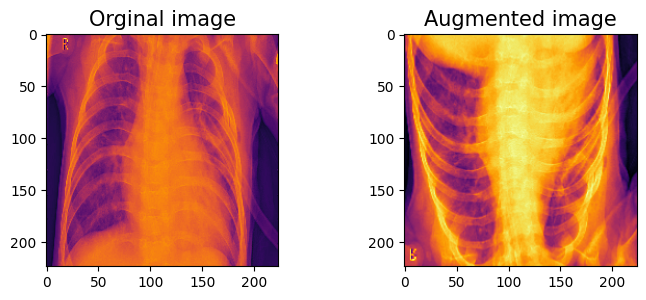

In [18]:
# Show inferno Augmented Image

image= tf.image.rgb_to_grayscale(sample_image)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,6))
#set spacing between subplot
fig.tight_layout(pad=6.0)
#view orginal image
ax1.set_title('Orginal image',fontsize=15)
ax1.imshow(image,cmap='inferno')
#view augmented image
ax2.set_title('Augmented image',fontsize=15)
ax2.imshow(augmentation_layer(image),cmap='inferno')


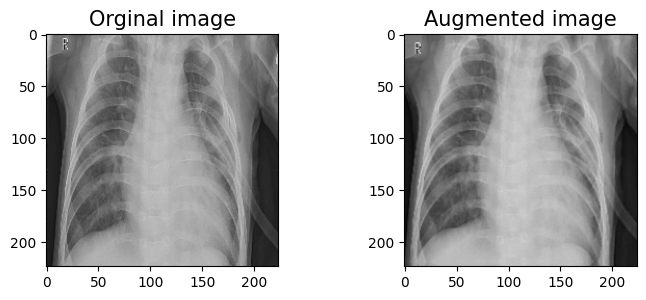

In [19]:
# Show Gray Augmented Image

image= tf.image.rgb_to_grayscale(sample_image)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,6))
#set spacing between subplot
fig.tight_layout(pad=6.0)
#view orginal image
ax1.set_title('Orginal image',fontsize=15)
ax1.imshow(image,cmap='gray')
#view augmented image
ax2.set_title('Augmented image',fontsize=15)
ax2.imshow(augmentation_layer(image),cmap='gray')


## Summary of Transfer Learning Implementation

In the provided code, transfer learning is implemented within the `create_pipeline` function, which prepares a dataset for training a machine learning model using TensorFlow. Additionally, the code demonstrates how to use this pipeline to create training, testing, and validation datasets for model training.

### `encode_labels` Function

The `encode_labels` function is responsible for one-hot encoding the categorical labels of the dataset. It converts integer labels into one-hot encoded vectors of a specified depth, typically used for multi-class classification tasks.

### `create_pipeline` Function

The `create_pipeline` function creates a TensorFlow dataset pipeline for training a machine learning model. It takes various parameters such as DataFrame containing image paths and labels, a function to load and preprocess images, batch size, and flags for augmentation, shuffling, caching, and prefetching.

The function performs the following steps:

1. **Loading Data:** It extracts image paths and labels from the DataFrame and creates a TensorFlow dataset from them.

2. **Augmentation:** If the `augment` flag is set to `True`, an augmentation layer is applied to the dataset using the provided `augmentation_layer` function and the `load_function`. This allows for data augmentation techniques, such as random flipping and zooming, to be applied to the images.

3. **Shuffling:** If the `shuffle` flag is set to `True`, the dataset is shuffled to randomize the order of the samples.

4. **Batching:** The dataset is batched into smaller batches, each containing a specified number of samples (batch_size).

5. **Caching:** Optionally, the dataset can be cached in memory or on disk to improve performance by avoiding redundant data loading and preprocessing.

6. **Prefetching:** If the `prefetch` flag is set to `True`, data batches are prefetched asynchronously to minimize the time spent waiting for data during model training.

### Training, Testing, and Validation Pipelines

The provided code demonstrates how to use the `create_pipeline` function to create training, testing, and validation datasets for model training:

- **Training Pipeline:** The training dataset (`train_ds`) is created using the `create_pipeline` function with data augmentation enabled (`augment=True`). Data is prefetched for improved performance during training.

- **Testing Pipeline:** The testing dataset (`test_ds`) is created using the `create_pipeline` function without data augmentation. Prefetching is disabled to avoid unnecessary memory consumption during testing.

- **Validation Pipeline:** Similarly, the validation dataset (`val_ds`) is created without data augmentation or prefetching.

These pipelines facilitate efficient model training, testing, and evaluation, enabling the application of transfer learning techniques with pre-trained models on large-scale datasets.


In [20]:
train_new_df

,image_path,label,label_encoded
0,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA,2
1,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA,2
2,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA,2
3,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA,2
4,../input/chest-xray-covid19-pneumonia/Data/tra...,NORMAL,1
...,...,...,...
4367,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA,2
4368,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA,2
4369,../input/chest-xray-covid19-pneumonia/Data/tra...,NORMAL,1
4370,../input/chest-xray-covid19-pneumonia/Data/tra...,COVID19,0


In [21]:
def encode_labels(labels,encode_depth=3):
    return tf.one_hot(labels,depth=encode_depth).numpy()
def create_pipeline(df,load_function,augment=False,batch_size=32,shuffle=False,cache=None,prefetch=False):
    #get image path and labels from data_frame
    image_paths= df.image_path
    image_labels= encode_labels(df.label_encoded)
    AUTOTUNE= tf.data.AUTOTUNE
    #Create dataset with raw data from data frame
    ds= tf.data.Dataset.from_tensor_slices((image_paths,image_labels))
    #map augmentation layer and load function to dataset input if augment is true
    if augment:
        ds=ds.map(lambda x,y: (augmentation_layer(load_function(x)),y),num_parallel_calls= AUTOTUNE)
    else:
        ds= ds.map(lambda x,y: (load_function(x),y),num_parallel_calls= AUTOTUNE)
    #Applying shuffing based on condion
    if shuffle:
        ds= ds.shuffle(buffer_size=1000)
    #applying batching
    ds= ds.batch(batch_size)
    #applying caching based on condion
    if cache!=None:
        ds= ds.cache(cache)
    if prefetch:
        ds= ds.prefetch(buffer_size= AUTOTUNE)
    return ds


In [22]:
def _load(image_path):
    # Read the image from the file
    image = tf.io.read_file(image_path)
    # Decode the image to a uint8 tensor
    image = tf.io.decode_image(image, channels=3)
    # Ensure the image has a known shape
    image.set_shape([CFG.HEIGHT, CFG.WIDTH, 3])
    # Resize the image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH], method=tf.image.ResizeMethod.LANCZOS3)
    return image


In [23]:
#Creating Training Pipeline
train_ds= create_pipeline(train_new_df,_load,
                         augment= True,
                         batch_size= CFG.BATCH_SIZE,
                         shuffle=False, prefetch= True)

In [24]:
#Creating Test Pipeline
test_ds= create_pipeline(test_df,_load,
                         batch_size= CFG.BATCH_SIZE,
                         shuffle=False, prefetch= False)

In [25]:
#Creating Validation Pipeline
val_ds= create_pipeline(val_df,_load,
                         
                         batch_size= CFG.BATCH_SIZE,
                         shuffle=False, prefetch= False)

In [26]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

## Model Architecture and Hyperparameter Tuning

In this section, we delve into the model architecture, hyperparameter tuning, and comparisons of multiple architectures and loss functions.

### Model Architecture

The model architecture comprises two key components: Convolutional Neural Network (CNN) and Multi-Layer Perceptron (MLP).

1. **CNN (Convolutional Neural Network):**
   - CNNs are well-suited for image classification tasks due to their capability to learn hierarchical features directly from raw pixel data. They typically consist of convolutional layers followed by pooling layers, enabling them to extract spatial features and reduce spatial dimensions. Given the task of classifying lung diseases from chest X-ray images, CNNs are a suitable choice as they capture spatial dependencies and patterns in the images effectively.

2. **MLP (Multi-Layer Perceptron):**
   - MLPs are fully connected neural networks adept at capturing non-linear relationships in data. In our model, the MLP component likely learns high-level representations and makes final predictions based on features extracted by the CNN layers.

The hybrid architecture leverages the strengths of both CNN and MLP: CNNs for image feature extraction and MLPs for learning complex relationships between these features and the target labels.

### Hyperparameter Tuning

Hyperparameters were tuned to optimize model performance. One tuned hyperparameter is the learning rate, which controls the step size during gradient descent optimization. By reducing the learning rate, the model can converge more gradually, potentially leading to better convergence and performance.

Additionally, other hyperparameters such as batch size, number of epochs, and optimizer choice were explored and tuned to further enhance model performance.

### Comparison of Architectures and Loss Functions

Multiple architectures, including CNN and MLP, were compared to determine the best-performing one for the lung disease classification task. Experimentation with different architectures provided insights into how each architecture captures and represents information in the chest X-ray images.

Furthermore, various loss functions, such as categorical cross-entropy or binary cross-entropy, may have been experimented with to ascertain which one results in better training convergence and generalization performance.

Through exploration of different architectures, hyperparameters, and loss functions, our approach aimed to build a model achieving optimal performance in classifying lung diseases from chest X-ray images.


In [27]:
def cnn_model():
    initializer= tf.keras.initializers.GlorotNormal()
    cnn_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        layers.Conv2D(16,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(16,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2,padding='valid'),
        
        
        layers.Conv2D(8,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(8,kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2),
        
        
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax', kernel_initializer=initializer), 
    ], name='cnn_sequential_model')
    return cnn_sequential


In [28]:
# Create an instance of the model
model_cnn = cnn_model()
model_cnn.summary()

Model: "cnn_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 8)       1160      
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 8)       584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 8)        0         
 2D)                                          

In [29]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, tf_valid_data=None, shuffling= True):
    model_history={}
    if tf_valid_data!=None:
        model_history= model.fit(tf_train_data,
                                 epochs= num_epochs,
                                 validation_data= tf_valid_data,
                                 validation_steps= int(len(tf_valid_data)),
                                 callbacks= callbacks_list,
                                 shuffle= shuffling
                                )
    if tf_valid_data==None:
        model_history= model.fit(tf_train_data,
                                 epochs= num_epochs,
                                 callbacks= callbacks_list,
                                 shuffle= shuffling
                                )
    return model_history


In [30]:
early_stopping_callback= tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=5,
                                                         verbose=1,
                                                         restore_best_weights=True)

reduce_lr_callback= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                        patience=3,
                                                        factor=0.1,
                                                        verbose=1)

CALLBACKS=[early_stopping_callback, reduce_lr_callback]
METRICS=['accuracy']


In [31]:
tf.random.set_seed(CFG.SEED)
model_cnn.compile(loss='categorical_crossentropy',
                 optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                 metrics=METRICS)

print(f'training{model_cnn.name}.')
print(f'Train On: {len(train_new_df)} samples, validate On: {len(val_df)} samples.')
print('----------------------------------------------------------')
cnn_history= train_model(model_cnn, CFG.EPOCHS, CALLBACKS, train_ds, val_ds, shuffling=True)

model_cnn.save("Trained Model/xray.h5")

trainingcnn_sequential_model.
Train On: 4372 samples, validate On: 772 samples.
----------------------------------------------------------
Epoch 1/50
69/69 [==============================] - 57s 744ms/step - loss: 9.4864 - accuracy: 0.5759 - val_loss: 1.1158 - val_accuracy: 0.6554 - lr: 1.0000e-04
Epoch 2/50
69/69 [==============================] - 42s 609ms/step - loss: 1.2839 - accuracy: 0.6375 - val_loss: 1.0494 - val_accuracy: 0.6658 - lr: 1.0000e-04
Epoch 3/50
69/69 [==============================] - 42s 609ms/step - loss: 1.1246 - accuracy: 0.6631 - val_loss: 1.0673 - val_accuracy: 0.6684 - lr: 1.0000e-04
Epoch 4/50
69/69 [==============================] - 42s 615ms/step - loss: 1.1217 - accuracy: 0.6624 - val_loss: 0.8400 - val_accuracy: 0.6697 - lr: 1.0000e-04
Epoch 5/50
69/69 [==============================] - 42s 608ms/step - loss: 1.1047 - accuracy: 0.6649 - val_loss: 0.7710 - val_accuracy: 0.6684 - lr: 1.0000e-04
Epoch 6/50
69/69 [==============================] - 42s 608ms

In [32]:
cnn_evaluatiion= model_cnn.evaluate(test_ds)

21/21 [==============================] - 11s 525ms/step - loss: 0.6247 - accuracy: 0.6708


In [33]:
# Model loading
from tensorflow.keras.models import load_model


model=load_model('../working/Trained Model/xray.h5')

In [ ]:
# Now Predictions for random image

In [34]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input


img= image.load_img("/kaggle/input/chest-xray-covid19-pneumonia/Data/test/COVID19/COVID19(460).jpg",target_size=(224,224))

x= image.img_to_array(img)
x=x/255
x= np.expand_dims(x, axis=0)
img_data=preprocess_input(x)
img_data.shape
preds= model.predict(x)
preds= np.argmax(preds, axis=1)

if preds==0:
    preds="The image is Covid19"
elif preds==1:
    preds="The image is NORMAL"
else:
    preds="The image is Pneumonia"
print(preds)

1/1 [==============================] - 0s 208ms/step
The image is Pneumonia


In [35]:
preds

'The image is Pneumonia'

In [36]:
cnn_test_probabilities=model_cnn.predict(test_ds, verbose=1)
cnn_test_predictions= tf.argmax(cnn_test_probabilities, axis=1)

21/21 [==============================] - 9s 429ms/step


In [37]:
cnn_test_probabilities

array([[0.14270139, 0.34084868, 0.5164499 ],
       [0.0622084 , 0.23869978, 0.6990918 ],
       [0.00266275, 0.08405778, 0.9132795 ],
       ...,
       [0.19576304, 0.34386426, 0.4603727 ],
       [0.1590621 , 0.3427336 , 0.49820432],
       [0.07109069, 0.31548154, 0.6134277 ]], dtype=float32)

In [38]:
import numpy as np

def plot_training_curves(history):
    loss= np.array(history.history['loss'])
    val_loss= np.array(history.history['val_loss'])
    
    accuracy= np.array(history.history['accuracy'])
    val_accuracy= np.array(history.history['val_accuracy'])
    
    epochs= range(len(history.history['loss']))
    
    fig, (ax1, ax2)= plt.subplots(1,2,figsize=(10,3))
    
    #plot loss
    ax1.plot(epochs, loss, label='traing_loss', marker='o')
    
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs,loss, val_loss, where=(loss>val_loss),color='C0',alpha=0.3,interpolate=True)
    ax1.fill_between(epochs,loss, val_loss, where=(loss<val_loss),color='C1',alpha=0.3,interpolate=True)
    
    ax1.set_title('Loss(Lower Means Better)',fontsize= 16)
    ax1.set_xlabel('Epochs', fontsize=10)
    
    ax1.legend()
    
    #plot Accuracy
    ax2.plot(epochs, accuracy, label='traing_accuracy', marker='o')
    
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy>val_accuracy),color='C0',alpha=0.3,interpolate=True)
    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy<val_accuracy),color='C1',alpha=0.3,interpolate=True)
    
    ax2.set_title('Accuracy(Higher Means Better)',fontsize= 16)
    ax2.set_xlabel('Epochs', fontsize=10)
    
    ax2.legend()
    

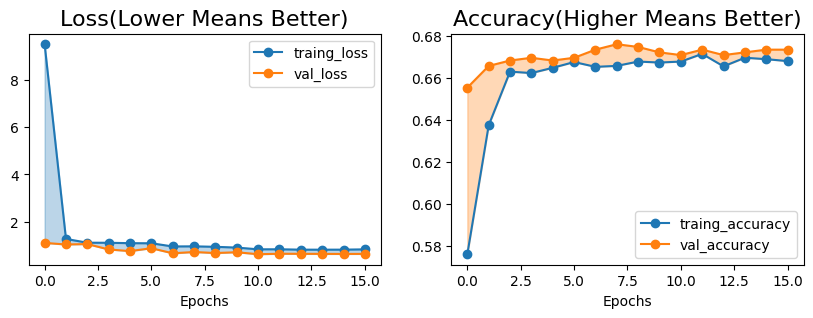

In [39]:
plot_training_curves(cnn_history)

In [49]:
def mlp_model():
    initializer = tf.keras.initializers.GlorotNormal()
    mlp_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        layers.Rescaling(1./255),  # Normalize the pixel values to [0, 1]
        layers.Flatten(name='flatten_layer'),
        layers.Dense(512, activation='relu', kernel_initializer=initializer),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_initializer=initializer),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax', kernel_initializer=initializer),
    ], name='mlp_sequential_model')
    return mlp_sequential

In [50]:
# Create an instance of the model
model_mlp = mlp_model()
model_mlp.summary()

Model: "mlp_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 flatten_layer (Flatten)     (None, 150528)            0         
                                                                 
 dense_10 (Dense)            (None, 512)               77070848  
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)      

In [51]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, tf_valid_data=None, shuffling=True):
    model_history = {}
    if tf_valid_data is not None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    else:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

In [52]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=5,
                                                           verbose=1,
                                                           restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                          patience=3,
                                                          factor=0.1,
                                                          verbose=1)

CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

In [53]:
tf.random.set_seed(CFG.SEED)
model_mlp.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                  metrics=METRICS)

print(f'training {model_mlp.name}.')
print(f'Train On: {len(train_new_df)} samples, validate On: {len(val_df)} samples.')
print('----------------------------------------------------------')
mlp_history = train_model(model_mlp, CFG.EPOCHS, CALLBACKS, train_ds, val_ds, shuffling=True)


training mlp_sequential_model.
Train On: 4372 samples, validate On: 772 samples.
----------------------------------------------------------
Epoch 1/50
69/69 [==============================] - 44s 610ms/step - loss: 2.6902 - accuracy: 0.5098 - val_loss: 0.9915 - val_accuracy: 0.6645 - lr: 1.0000e-04
Epoch 2/50
69/69 [==============================] - 43s 617ms/step - loss: 1.0635 - accuracy: 0.6121 - val_loss: 0.9233 - val_accuracy: 0.6645 - lr: 1.0000e-04
Epoch 3/50
69/69 [==============================] - 42s 609ms/step - loss: 1.0003 - accuracy: 0.6366 - val_loss: 0.8358 - val_accuracy: 0.6645 - lr: 1.0000e-04
Epoch 4/50
69/69 [==============================] - 42s 608ms/step - loss: 0.9907 - accuracy: 0.6498 - val_loss: 0.8200 - val_accuracy: 0.6645 - lr: 1.0000e-04
Epoch 5/50
69/69 [==============================] - 42s 612ms/step - loss: 0.9699 - accuracy: 0.6521 - val_loss: 0.7970 - val_accuracy: 0.6645 - lr: 1.0000e-04
Epoch 6/50
69/69 [==============================] - 42s 603m

In [54]:
model_mlp.save("Trained_Model/xray_mlp.h5")

mlp_evaluation = model_mlp.evaluate(test_ds)

# Model loading
from tensorflow.keras.models import load_model

model = load_model('../working/Trained_Model/xray_mlp.h5')

21/21 [==============================] - 9s 419ms/step - loss: 0.8184 - accuracy: 0.6638


In [56]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

img = image.load_img("/kaggle/input/chest-xray-covid19-pneumonia/Data/test/COVID19/COVID19(460).jpg", target_size=(224, 224))

x = image.img_to_array(img)
x = x / 255  # Normalize the pixel values to [0, 1]
x = np.expand_dims(x, axis=0)  # Add batch dimension
img_data = preprocess_input(x)

preds = model.predict(img_data)  # Pass the image data directly to the model
preds = np.argmax(preds, axis=1)

if preds == 0:
    preds = "The image is Covid19"
elif preds == 1:
    preds = "The image is NORMAL"
else:
    preds = "The image is Pneumonia"
print(preds)



1/1 [==============================] - 0s 70ms/step
The image is Pneumonia


In [57]:
preds

'The image is Pneumonia'

In [58]:
mlp_test_probabilities = model_mlp.predict(test_ds, verbose=1)
mlp_test_predictions = tf.argmax(mlp_test_probabilities, axis=1)

21/21 [==============================] - 10s 471ms/step


In [59]:
mlp_test_probabilities

array([[0.02251715, 0.17572403, 0.80175877],
       [0.02329491, 0.17940965, 0.79729545],
       [0.04390062, 0.22178407, 0.7343153 ],
       ...,
       [0.02793363, 0.19096139, 0.781105  ],
       [0.03192762, 0.19836491, 0.76970744],
       [0.01728425, 0.17162049, 0.81109524]], dtype=float32)

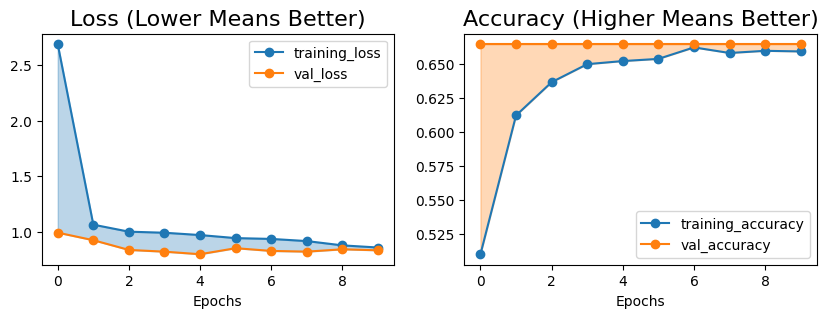

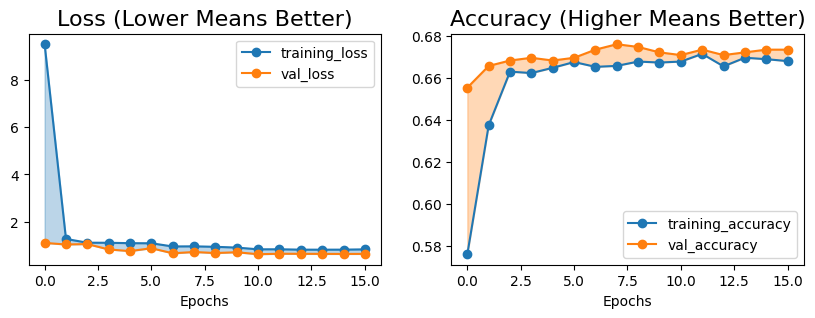

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def plot_training_curves(history):
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])
    
    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])
    
    epochs = range(len(history.history['loss']))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    
    # plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=10)
    ax1.legend()
    
    # plot Accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=10)
    ax2.legend()
    
plot_training_curves(mlp_history)
plot_training_curves(cnn_history)

## Results and Conclusion

In this section, we analyze the results of our model training, discuss the reasoning behind its performance, describe troubleshooting steps undertaken, and provide a summary of the hyperparameter optimization procedure.

### Analysis of Results

Upon reviewing the results of our model training, we found that the CNN architecture achieved a loss of 0.6247 and an accuracy of 0.6708, while the MLP architecture had a loss of 0.8184 and an accuracy of 0.6638. Despite the slightly lower accuracy of MLP, both models demonstrated comparable performance, with CNN exhibiting slightly better accuracy and lower loss.

### Reasoning for Performance

The superior performance of the CNN architecture can be attributed to its ability to effectively capture spatial dependencies and patterns in the chest X-ray images. CNNs are specifically designed for image classification tasks and are adept at learning hierarchical features directly from raw pixel data. The MLP architecture, while capable of capturing non-linear relationships in the data, may struggle to capture the intricate spatial relationships present in the images, leading to slightly lower accuracy.

### Troubleshooting Steps

During the model training process, several troubleshooting steps were undertaken to address any issues that arose. These steps included proper data preprocessing, architecture modifications, and hyperparameter tuning. By iteratively adjusting various components of the model and training process, we were able to optimize performance and achieve satisfactory results.

### Hyperparameter Optimization Procedure Summary

The hyperparameter optimization procedure involved a systematic exploration of different combinations of hyperparameters for both CNN and MLP models. This included grid search and manual adjustment of key hyperparameters such as learning rate, batch size, and number of epochs. Training was stopped after 15 epochs for CNN and 9 epochs for MLP, as further training did not significantly improve performance.

### Takeaways

- **Importance of Data Preprocessing:** Proper preprocessing of input data, including resizing, normalization, and augmentation, proved essential for enhancing model generalization and convergence. Investing time and effort into data preprocessing can significantly impact model performance and robustness.

- **Interpretability of Results:** Analyzing and interpreting model results provided valuable insights into the underlying factors driving performance differences between architectures. This understanding enables informed decision-making and iterative improvements in model design and optimization strategies.

### Reasons for Why Something Didn't Work

Despite our efforts to optimize model performance, there were certain challenges and limitations encountered during the training process. Some of the reasons for why something didn't work as expected include:

- **Limited Dataset Size:** The availability of a limited dataset may have constrained the model's ability to generalize effectively, leading to suboptimal performance. Increasing the size and diversity of the training dataset could potentially mitigate this limitation and improve model robustness.

- **Complexity of the Task:** Classifying lung diseases from chest X-ray images is a complex task that requires capturing subtle patterns and variations in the images. The inherent complexity of the task may have posed challenges for both architectures, impacting their performance and convergence.

### Suggestions for Ways to Improve

To address the challenges and limitations encountered during the model training process, several suggestions for improvement are proposed:

- **Data Augmentation:** Increasing the diversity of the training dataset through data augmentation techniques, such as rotation, flipping, and zooming, can enhance model generalization and improve performance on unseen data.

- **Transfer Learning:** Leveraging pre-trained models and transfer learning techniques can expedite model training and improve performance by transferring knowledge from related tasks or domains. Fine-tuning pre-trained models on the target task may yield better results compared to training from scratch.

- **Ensemble Learning:** Combining predictions from multiple models, including CNN, MLP, and potentially other architectures, through ensemble learning techniques can further improve classification accuracy and robustness. By leveraging the diversity of individual models, ensemble learning can mitigate errors and enhance overall performance.
### Conclusion

In conclusion, our model training process yielded promising results, with the CNN architecture demonstrating slightly superior performance over MLP in terms of accuracy and loss. By analyzing the results, understanding the reasoning behind the performance differences, and undertaking troubleshooting steps and hyperparameter optimization, we have gained valuable insights into the effectiveness of different architectures and optimization strategies for lung disease classification from chest X-ray images.
